In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Classes for preprocessing, clustering, PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
import plotly.express as px
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/daniel-bss/credit-card-clustering/main/CC%20GENERAL.csv', index_col = 'CUST_ID') # Set the customer's ID as index
print(data.shape)
data.head()

(8950, 17)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
# Step 1: Data Understanding and Cleaning

# Check for missing values per column
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Basic statistics summary
print("\nSummary statistics:\n", data.describe())

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Handle missing values - example: fill missing 'MINIMUM_PAYMENTS' with median
if 'MINIMUM_PAYMENTS' in data.columns:
    median_min_pay = data['MINIMUM_PAYMENTS'].median()
    data['MINIMUM_PAYMENTS'].fillna(median_min_pay, inplace=True)
    print(f"\nFilled missing MINIMUM_PAYMENTS with median: {median_min_pay}")

# Confirm no more missing values after filling
print("\nMissing values after filling:\n", data.isnull().sum())


Missing values in each column:
 BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Summary statistics:
             BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0

C:\Users\abhir\AppData\Local\Temp\ipykernel_22364\3797727776.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['MINIMUM_PAYMENTS'].fillna(median_min_pay, inplace=True)


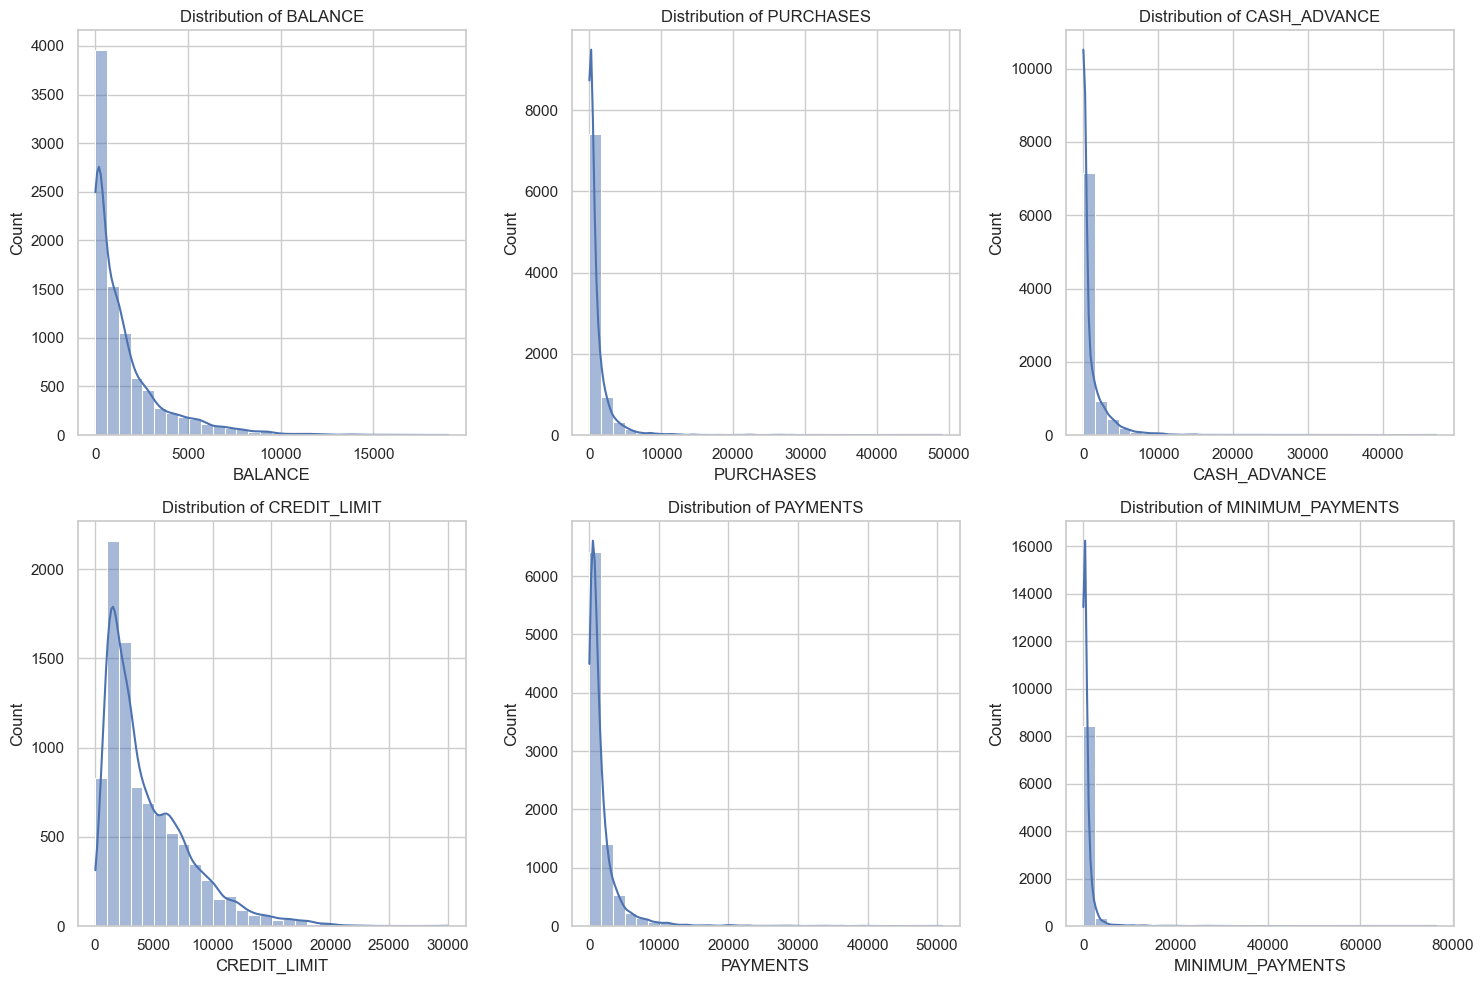

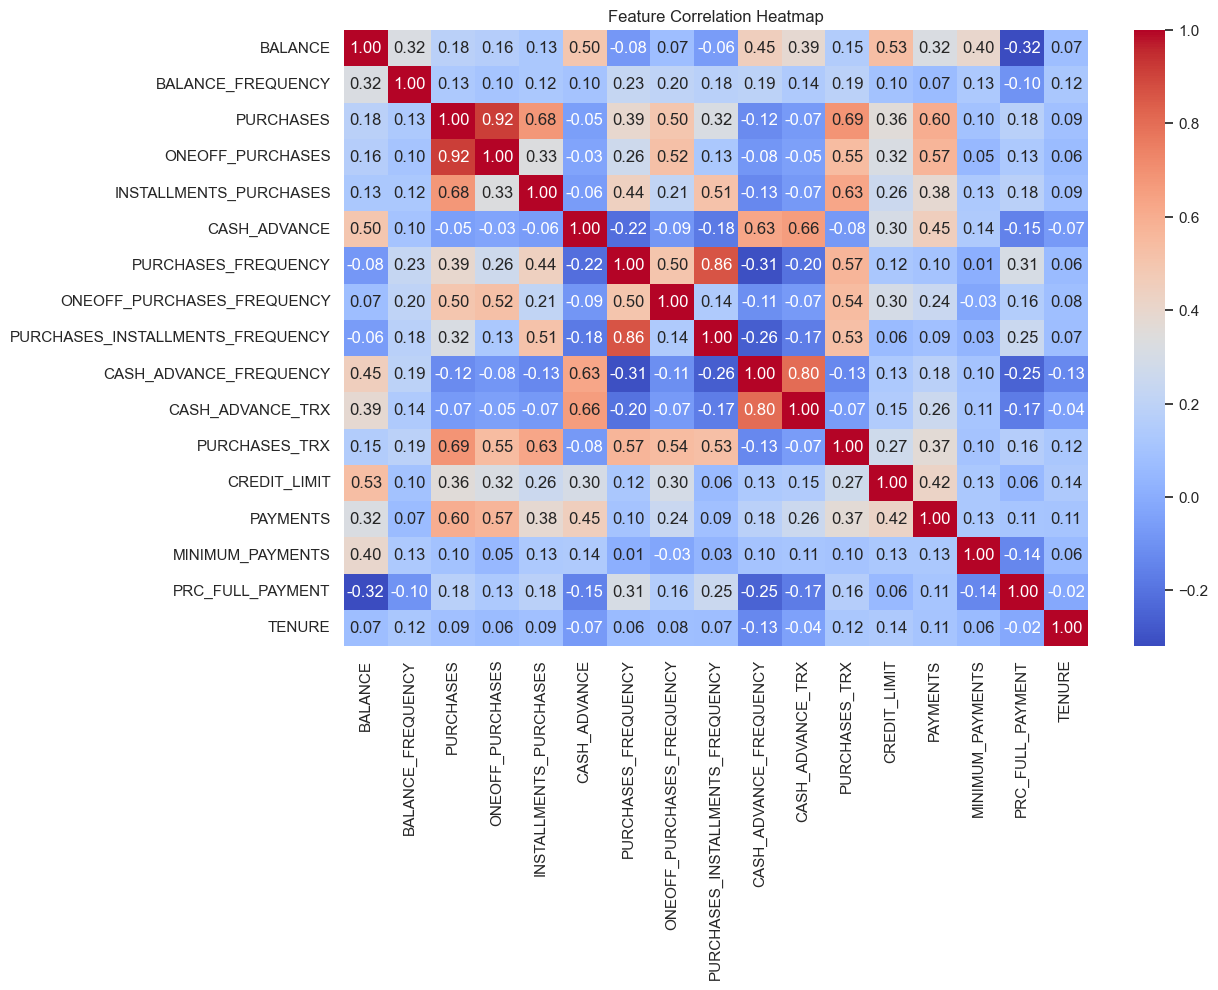

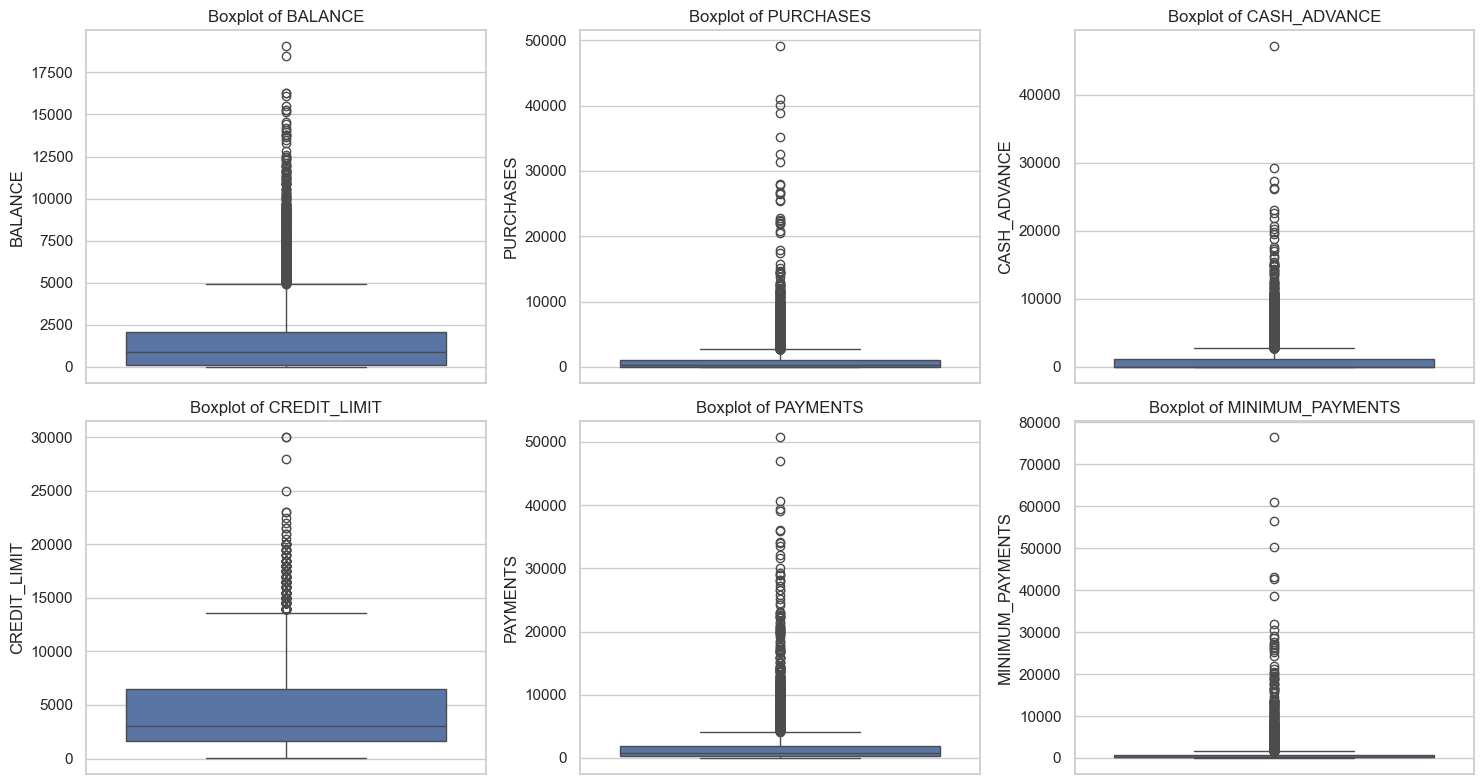

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

# 1. Visualize distributions of key numeric features
features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# 2. Correlation heatmap to see relationships among features
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# 3. Boxplots to check for outliers in selected features
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=data[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()


In [7]:
data['payment_to_balance_ratio'] = data['PAYMENTS'] / (data['BALANCE'] + 1)
data['min_payment_to_balance_ratio'] = data['MINIMUM_PAYMENTS'] / (data['BALANCE'] + 1)
data['oneoff_to_total_purchases_ratio'] = data['ONEOFF_PURCHASES'] / (data['PURCHASES'] + 1)
data['avg_purchase_amount'] = data['PURCHASES'] / (data['PURCHASES_TRX'] + 1)
data['credit_utilization'] = data.apply(lambda x: x['BALANCE'] / x['CREDIT_LIMIT'] if x['CREDIT_LIMIT'] > 0 else 0, axis=1)
data['cash_advance_ratio'] = data['CASH_ADVANCE_TRX'] / (data['PURCHASES_TRX'] + data['CASH_ADVANCE_TRX'] + 1)
# 'PRC_FULL_PAYMENT' is already a useful feature for payment behavior


In [8]:
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,payment_to_balance_ratio,min_payment_to_balance_ratio,oneoff_to_total_purchases_ratio,avg_purchase_amount,credit_utilization,cash_advance_ratio
CUST_ID,,,,,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,201.802084,139.509787,0.000000,12,4.816193,3.329530,0.000000,31.800000,0.040901,0.000000
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,4103.032597,1072.340217,0.222222,12,1.280810,0.334744,0.000000,0.000000,0.457495,0.800000
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,622.066742,627.284787,0.000000,12,0.249211,0.251301,0.998708,59.474615,0.332687,0.000000
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0.000000,312.343947,0.000000,12,0.000000,0.187294,0.999333,749.500000,0.222223,0.333333
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,678.334763,244.791237,0.000000,12,0.828537,0.298995,0.941176,8.000000,0.681429,0.000000


In [9]:
from sklearn.preprocessing import StandardScaler

# Select features to scale (including the engineered ones)
features_to_scale = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS',
                     'payment_to_balance_ratio', 'min_payment_to_balance_ratio', 'oneoff_to_total_purchases_ratio', 
                     'avg_purchase_amount', 'credit_utilization', 'cash_advance_ratio']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features_to_scale])

# Create a DataFrame of scaled features for clarity
scaled_data = pd.DataFrame(scaled_features, columns=features_to_scale, index=data.index)

# Display first few rows
scaled_data.head()


,BALANCE,PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,payment_to_balance_ratio,min_payment_to_balance_ratio,oneoff_to_total_purchases_ratio,avg_purchase_amount,credit_utilization,cash_advance_ratio
CUST_ID,,,,,,,,,,,,
C10001,-0.731989,-0.424900,-0.466786,-0.960380,-0.528979,-0.302400,-0.055001,-0.060962,-0.890872,-0.245761,-0.892948,-0.766365
C10002,0.786961,-0.469552,2.605605,0.688601,0.818642,0.097500,-0.072201,-0.158063,-0.890872,-0.542582,0.176064,1.604821
C10003,0.447135,-0.107668,-0.466786,0.826016,-0.383805,-0.093293,-0.077220,-0.160769,1.467884,0.012553,-0.144204,-0.766365
C10004,0.049099,0.232058,-0.368653,0.826016,-0.598688,-0.228307,-0.078433,-0.162844,1.469360,6.453240,-0.427662,0.221630
C10005,-0.358775,-0.462063,-0.466786,-0.905414,-0.364368,-0.257266,-0.074402,-0.159222,1.332005,-0.467910,0.750694,-0.766365


In [13]:
# Check for missing values in scaled data
print(scaled_data.isnull().sum())

# Impute missing values with column median
scaled_data = scaled_data.fillna(scaled_data.median())

# Verify no missing values remain
print(scaled_data.isnull().sum())


BALANCE                            0
PURCHASES                          0
CASH_ADVANCE                       0
CREDIT_LIMIT                       1
PAYMENTS                           0
MINIMUM_PAYMENTS                   0
payment_to_balance_ratio           0
min_payment_to_balance_ratio       0
oneoff_to_total_purchases_ratio    0
avg_purchase_amount                0
credit_utilization                 0
cash_advance_ratio                 0
dtype: int64
BALANCE                            0
PURCHASES                          0
CASH_ADVANCE                       0
CREDIT_LIMIT                       0
PAYMENTS                           0
MINIMUM_PAYMENTS                   0
payment_to_balance_ratio           0
min_payment_to_balance_ratio       0
oneoff_to_total_purchases_ratio    0
avg_purchase_amount                0
credit_utilization                 0
cash_advance_ratio                 0
dtype: int64


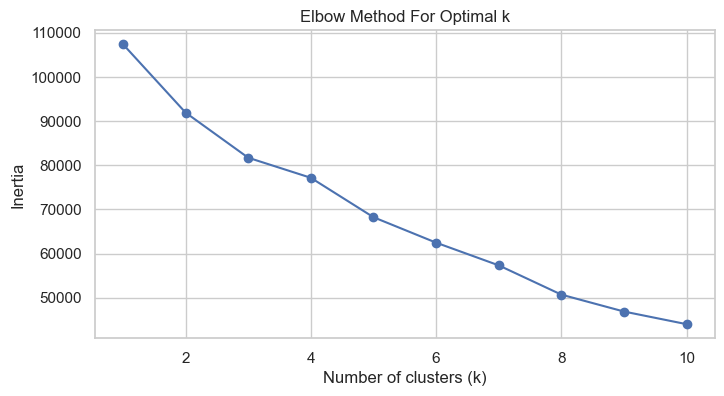

In [14]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
# Use your chosen k
k = 4  # Or k = 3 if you prefer
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Assign cluster labels
data['Cluster'] = cluster_labels

# Profile clusters: mean of each feature per cluster
cluster_profiles = data.groupby('Cluster').mean()
print(cluster_profiles)

# Optional: See the number of customers in each cluster
print("\nNumber of customers in each cluster:")
print(data['Cluster'].value_counts())


             BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0        6008.006043           0.964491  3280.306796       2132.101525   
1         340.939445           0.794436  1060.128662        550.789311   
2        1894.656617           0.908001    57.483374         10.999552   
3        1936.754061           0.975185  1021.047612        701.546063   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                   1148.320194   4531.434153             0.546343   
1                    509.855989     83.434717             0.662923   
2                     46.493154   1739.933022             0.083826   
3                    319.752181    587.395403             0.557701   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                      

In [17]:
# Loop through each cluster and show describe() statistics for all features
for cluster_num in sorted(data['Cluster'].unique()):
    print(f"\nSummary statistics for Cluster {cluster_num}:")
    display(data[data['Cluster'] == cluster_num].describe())



Summary statistics for Cluster 0:


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,payment_to_balance_ratio,min_payment_to_balance_ratio,oneoff_to_total_purchases_ratio,avg_purchase_amount,credit_utilization,cash_advance_ratio,Cluster
count,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,...,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.0
mean,6008.006043,0.964491,3280.306796,2132.101525,1148.320194,4531.434153,0.546343,0.322712,0.423498,0.333896,...,3186.717103,0.085230,11.711886,12.177340,0.847685,0.461455,100.094358,0.586672,0.416807,0.0
std,3091.213862,0.123688,5679.509492,4548.207666,2249.520354,4693.309587,0.415880,0.354446,0.422721,0.279228,...,6160.456383,0.217520,1.039175,197.756478,7.367873,0.407397,234.643610,0.264324,0.353089,0.0
min,4.382924,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.950090,0.000000,6.000000,0.000000,0.034077,0.000000,0.000000,0.000313,0.000000,0.0
25%,3792.684929,1.000000,86.655000,0.000000,0.000000,600.679698,0.083333,0.000000,0.000000,0.083333,...,1150.817954,0.000000,12.000000,0.269234,0.246192,0.000000,18.022276,0.400791,0.047199,0.0
50%,5860.024126,1.000000,1013.455000,397.720000,217.645000,3627.713684,0.583333,0.166667,0.333333,0.286363,...,1825.348910,0.000000,12.000000,0.677275,0.291724,0.482166,55.448611,0.607616,0.383484,0.0
75%,7830.637813,1.000000,4113.500000,2266.595000,1323.277500,6537.253679,1.000000,0.583333,0.916667,0.500000,...,2818.717655,0.083333,12.000000,2.126965,0.402362,0.887861,101.421152,0.788675,0.777211,0.0
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.250000,...,76406.207520,1.000000,12.000000,5385.358196,202.898055,0.999955,4486.250000,2.033580,0.991935,0.0



Summary statistics for Cluster 1:


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,payment_to_balance_ratio,min_payment_to_balance_ratio,oneoff_to_total_purchases_ratio,avg_purchase_amount,credit_utilization,cash_advance_ratio,Cluster
count,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,...,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.0
mean,340.939445,0.794436,1060.128662,550.789311,509.855989,83.434717,0.662923,0.237937,0.515476,0.019905,...,231.386465,0.298402,11.556166,31.131498,10.729018,0.391305,64.395967,0.082183,0.028377,1.0
std,552.660929,0.290091,1325.660899,1007.693174,710.516202,359.592766,0.339217,0.323535,0.384846,0.067973,...,333.522495,0.365652,1.303492,291.636333,45.352281,0.412295,70.559597,0.106579,0.097955,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.019163,0.000000,6.000000,0.000000,0.019138,0.000000,0.000000,0.000000,0.000000,1.0
25%,28.926756,0.636364,225.005000,0.000000,51.445000,0.000000,0.333333,0.000000,0.083333,0.000000,...,127.034539,0.000000,12.000000,2.359674,0.492787,0.000000,25.000000,0.009321,0.000000,1.0
50%,110.405139,1.000000,552.920000,90.255000,277.385000,0.000000,0.750000,0.083333,0.500000,0.000000,...,171.521108,0.090909,12.000000,7.689065,1.354388,0.242548,45.508217,0.034806,0.000000,1.0
75%,392.084443,1.000000,1350.127500,684.072500,655.845000,0.000000,1.000000,0.333333,0.916667,0.000000,...,221.912727,0.571429,12.000000,13.657386,4.188621,0.834430,77.250000,0.113765,0.000000,1.0
max,4920.036231,1.000000,9934.930000,8945.670000,7571.400000,7894.578816,1.000000,1.000000,1.000000,0.857143,...,4887.636705,1.000000,12.000000,14229.882480,312.343947,1.798389,1300.000000,0.589442,0.750000,1.0



Summary statistics for Cluster 2:


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,payment_to_balance_ratio,min_payment_to_balance_ratio,oneoff_to_total_purchases_ratio,avg_purchase_amount,credit_utilization,cash_advance_ratio,Cluster
count,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,...,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.0
mean,1894.656617,0.908001,57.483374,10.999552,46.493154,1739.933022,0.083826,0.010861,0.069775,0.286990,...,802.260615,0.037079,11.285114,3.780570,0.682534,0.039446,6.573449,0.588409,0.719216,2.0
std,1511.317990,0.195458,192.830771,61.013388,165.942029,1602.658182,0.232400,0.051500,0.209628,0.200721,...,1281.885140,0.116758,1.589648,50.800254,2.087113,0.174064,19.394730,0.301783,0.182604,0.0
min,0.144460,0.090909,0.000000,0.000000,0.000000,18.042768,0.000000,0.000000,0.000000,0.083333,...,4.363375,0.000000,6.000000,0.000000,0.044460,0.000000,0.000000,0.000021,0.081967,2.0
25%,841.702350,0.909091,0.000000,0.000000,0.000000,468.487356,0.000000,0.000000,0.000000,0.142857,...,283.346242,0.000000,12.000000,0.241165,0.259762,0.000000,0.000000,0.345155,0.560386,2.0
50%,1450.649137,1.000000,0.000000,0.000000,0.000000,1297.777178,0.000000,0.000000,0.000000,0.250000,...,476.830891,0.000000,12.000000,0.366400,0.333535,0.000000,0.000000,0.620757,0.750000,2.0
75%,2655.266305,1.000000,0.000000,0.000000,0.000000,2560.805826,0.000000,0.000000,0.000000,0.416667,...,910.896477,0.000000,12.000000,1.380885,0.471964,0.000000,0.000000,0.873507,0.875000,2.0
max,7659.191510,1.000000,2253.980000,920.540000,1800.000000,9579.677222,1.000000,0.800000,1.000000,1.500000,...,17563.485420,1.000000,12.000000,2247.221942,67.212413,0.998594,219.843750,2.325422,0.984127,2.0



Summary statistics for Cluster 3:


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,payment_to_balance_ratio,min_payment_to_balance_ratio,oneoff_to_total_purchases_ratio,avg_purchase_amount,credit_utilization,cash_advance_ratio,Cluster
count,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,...,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.000000,2027.0
mean,1936.754061,0.975185,1021.047612,701.546063,319.752181,587.395403,0.557701,0.288982,0.354911,0.126466,...,1208.296914,0.017226,11.611741,1.007704,0.753799,0.674232,84.228450,0.708552,0.166028,3.0
std,1310.119880,0.090859,1187.699552,993.784443,527.954137,937.214530,0.348709,0.284864,0.389817,0.172065,...,2151.013309,0.070189,1.177160,2.006207,1.356796,0.385373,123.349884,0.424493,0.231726,0.0
min,69.399150,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,50.055024,0.000000,6.000000,0.000000,0.051535,0.000000,0.000000,0.053094,0.000000,3.0
25%,1007.928213,1.000000,251.160000,69.400000,0.000000,0.000000,0.181818,0.083333,0.000000,0.000000,...,383.568689,0.000000,12.000000,0.277873,0.269148,0.374596,31.322143,0.479865,0.000000,3.0
50%,1529.206464,1.000000,600.000000,339.000000,79.000000,49.167984,0.571429,0.166667,0.166667,0.083333,...,678.731919,0.000000,12.000000,0.462519,0.375097,0.874453,49.307692,0.743524,0.033333,3.0
75%,2554.919583,1.000000,1343.005000,965.045000,436.850000,912.454788,0.916667,0.416667,0.750000,0.181818,...,1166.367383,0.000000,12.000000,1.045174,0.632930,0.996008,83.606000,0.919605,0.272727,3.0
max,6976.346140,1.000000,8834.960000,8269.360000,5463.730000,5676.779668,1.000000,1.000000,1.000000,1.125000,...,28483.254830,1.000000,12.000000,48.754443,13.062365,1.692545,1450.000000,15.909951,0.928571,3.0


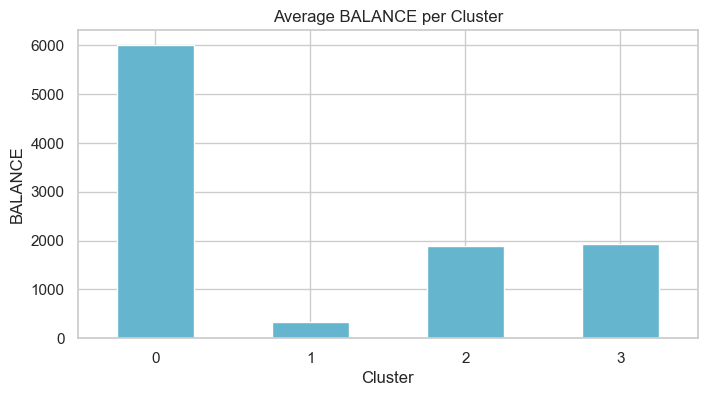

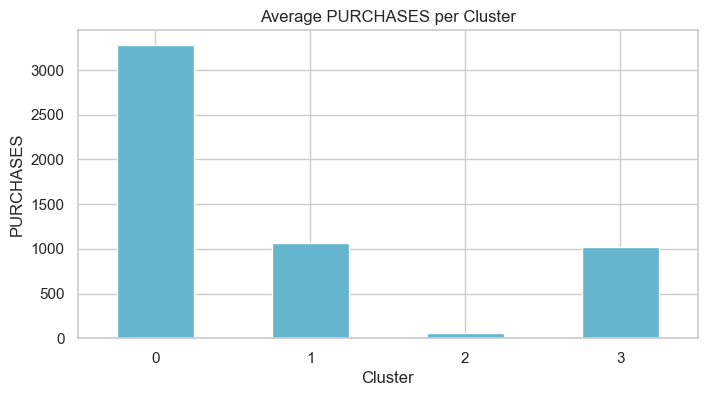

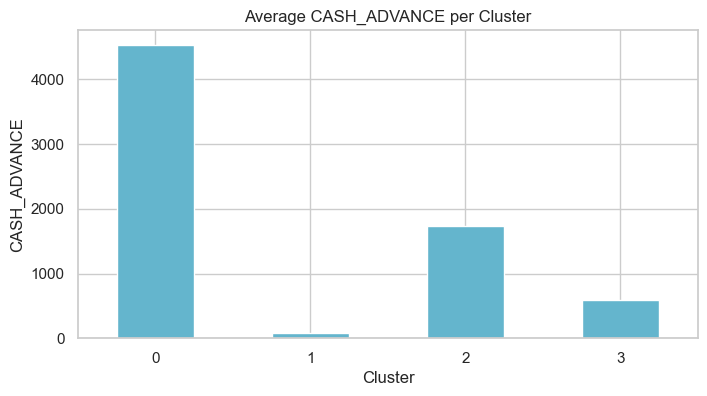

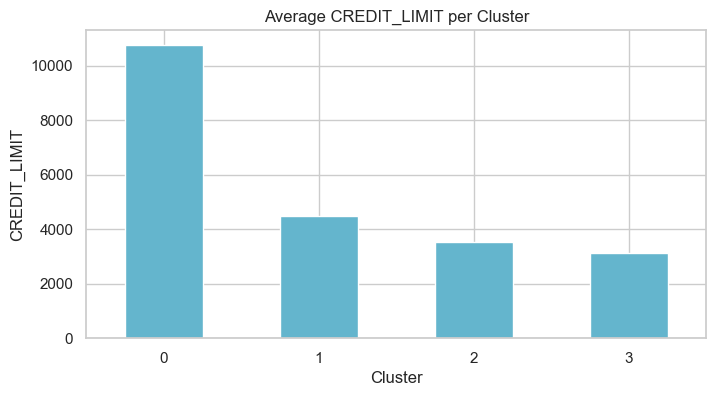

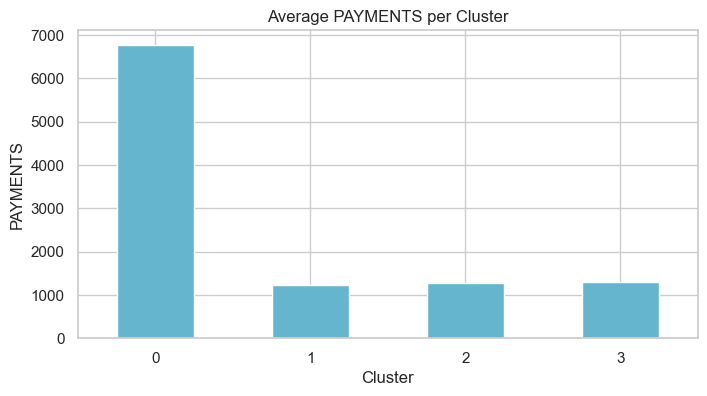

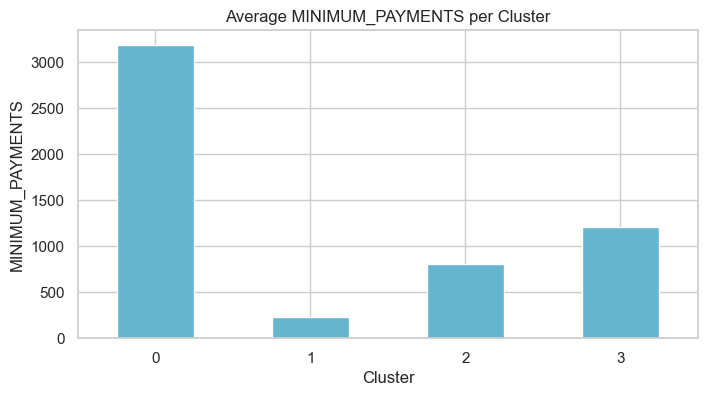

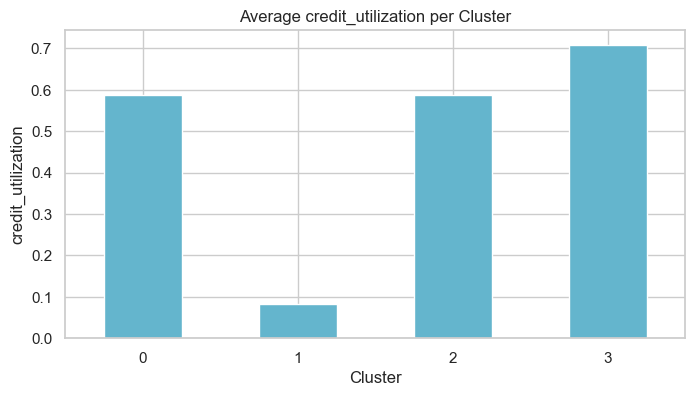

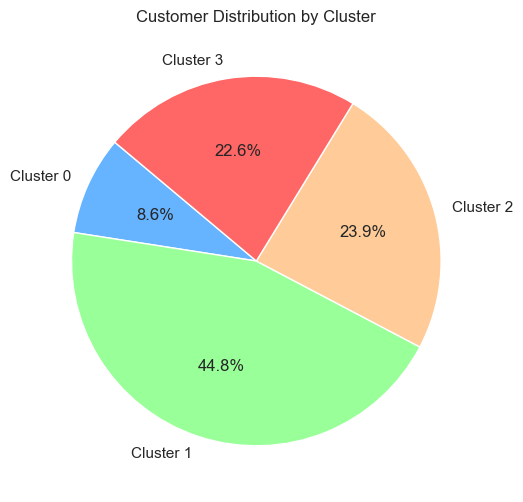

In [18]:
import matplotlib.pyplot as plt

# Bar plots for average feature values per cluster
features_to_plot = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'credit_utilization']

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    cluster_means = data.groupby('Cluster')[feature].mean()
    cluster_means.plot(kind='bar', color='c')
    plt.title(f'Average {feature} per Cluster')
    plt.ylabel(feature)
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.show()

# Pie chart for cluster size distribution
plt.figure(figsize=(6, 6))
cluster_sizes = data['Cluster'].value_counts().sort_index()
colors = ['#66b3ff','#99ff99','#ffcc99','#ff6666']
plt.pie(cluster_sizes, labels=[f'Cluster {i}' for i in cluster_sizes.index],
        autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Customer Distribution by Cluster')
plt.show()
